In [1]:

import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to your device

import time
import numpy as np

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.activations import elu, relu, selu, sigmoid, hard_sigmoid, linear
from keras.layers.advanced_activations import LeakyReLU, PReLU

from keras.layers import Dense, Lambda, Input, concatenate, Layer, Dropout
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Adadelta

from keras import backend as K


Using TensorFlow backend.


### Data wrangling before train

In [11]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows * img_cols)
x_test = x_test.reshape(x_test.shape[0], img_rows * img_cols)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 784)
60000 train samples
10000 test samples


### Hyper Parameters:

In [25]:
PERMUT_OFF = 5  # how many modified offspring per generation (1 is always the starting value)

m_params = {}

# true constants that won't change during training
m_params["MAX_GOAL_TIME"] = 45.0 # target max seconds per run, penalize for more time, slightly bonus for less time
m_params["BEST_TIME_BONUS"] = 1.1 # try to prevent the alg to ONLY make things faster

# constant only for a run
m_params["BATCH_SIZE"] = 2048      # [1 - 4096] (powers of 2)
m_params["EPOCHS"] = 40           # [10 - 50]
m_params["LEARNING_RATE"] = 0.01    # [1e1 - 1e-5]
m_params["LR_DECAY"] = 1e-5        # [1e-3 - 1e-5]

m_params["OPTIMIZER"] = Adam   # [Adadelta, Adam, RMSprop, SGD]

# dropout
# applies in the gab preceeding the label
# For example DO_B occurs in between NODES_DENSE_A and NODES_DENSE_B
m_params["DO_A"] = 0.2             # [0 - 1.0]
m_params["DO_B"] = 0.2             # [0 - 1.0]
m_params["DO_C"] = 0.2             # [0 - 1.0]
m_params["DO_D"] = 0.2             # [0 - 1.0]
m_params["DO_E"] = 0.2             # [0 - 1.0]
m_params["DO_F"] = 0.2  # if there is layer E there should be ability to have DO between last FC and activation

m_params["NODES_FC_A"] = 20        # [2 - 1000]
m_params["NODES_FC_B"] = 20        # [2 - 1000]
m_params["NODES_FC_C"] = 20        # [2 - 1000]
m_params["NODES_FC_D"] = 20        # [2 - 1000]
m_params["NODES_FC_E"] = 20        # [2 - 1000]

m_params["ACT_FC_A"] = "relu"     # [elu, relu, selu, sigmoid, hard_sigmoid, linear]
m_params["ACT_FC_B"] = "relu"     # [elu, relu, selu, sigmoid, hard_sigmoid, linear]
m_params["ACT_FC_C"] = "relu"     # [elu, relu, selu, sigmoid, hard_sigmoid, linear]
m_params["ACT_FC_D"] = "relu"     # [elu, relu, selu, sigmoid, hard_sigmoid, linear]
m_params["ACT_FC_E"] = "relu"     # [elu, relu, selu, sigmoid, hard_sigmoid, linear]


### Make sure that it's working

In [26]:
run_model(m_params)

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 2s 25us/step - loss: 1.7837 - acc: 0.3055 - val_loss: 0.9745 - val_acc: 0.6109
Epoch 2/40
60000/60000 [==============================] - 0s 6us/step - loss: 1.0967 - acc: 0.6345 - val_loss: 0.6082 - val_acc: 0.8445
Epoch 3/40
60000/60000 [==============================] - 0s 6us/step - loss: 0.8970 - acc: 0.7089 - val_loss: 0.5159 - val_acc: 0.8635
Epoch 4/40
60000/60000 [==============================] - 0s 6us/step - loss: 0.8288 - acc: 0.7429 - val_loss: 0.4694 - val_acc: 0.8843
Epoch 5/40
60000/60000 [==============================] - 0s 6us/step - loss: 0.7893 - acc: 0.7592 - val_loss: 0.4307 - val_acc: 0.8934
Epoch 6/40
60000/60000 [==============================] - 0s 6us/step - loss: 0.7620 - acc: 0.7722 - val_loss: 0.4233 - val_acc: 0.8962
Epoch 7/40
60000/60000 [==============================] - 0s 6us/step - loss: 0.7414 - acc: 0.7808 - val_loss: 0.4095 - val_acc: 0.89

(101.94800023078918, 92.68000020980834, 28, 17.42849898338318)

In [47]:
log = []

# in the future decide which 'gene' to MUTATE before the for loop.
mutation_keys = ["EPOCHS", "NEURONS", "NEURON_ACTIVATION", "LEARNING_RATE", "DROPOUT"]
# mutation_keys = ["NEURON_ACTIVATION"]

for generation in range(500):
    mutation_type = np.random.choice(mutation_keys)

    print("Generation {:}: {:}".format(generation + 1, mutation_type))
    
    ############################
    ### if mutating epochs:  ###
    ############################
    if mutation_type == "EPOCHS":
        # get current epoch
        mutations = [m_params[mutation_type]]

        # now make PERMUT_OFF permutations:
        while len(mutations) < PERMUT_OFF:
            temp_e = np.random.randint(-10, 10)
            temp_e += mutations[0]

            if 2 <= temp_e <= 150:
                if temp_e not in mutations:
                    mutations.append(temp_e)

    elif mutation_type == "NEURONS":
        mutation_type = np.random.choice(["NODES_FC_A", "NODES_FC_B", "NODES_FC_C", "NODES_FC_D", "NODES_FC_E"])

        mutations = [m_params[mutation_type]]

        while len(mutations) < PERMUT_OFF:
            temp = np.random.randint(-25, 25)
            temp += mutations[0]  # difference off the original value

            if 2 <= temp <= 200:
                if temp not in mutations:
                    mutations.append(temp)
                    
    elif mutation_type == "NEURON_ACTIVATION":
        mutation_type = np.random.choice(["ACT_FC_A", "ACT_FC_B", "ACT_FC_C", "ACT_FC_D", "ACT_FC_E"])
        
        mutations = [m_params[mutation_type]]
        
        while len(mutations) < PERMUT_OFF:
            temp = np.random.choice(["elu", "relu", "selu", "sigmoid", "hard_sigmoid", "linear", "tanh"])
            
            if temp not in mutations:
                mutations.append(temp)

    elif mutation_type == "LEARNING_RATE":
        mutations = [m_params[mutation_type]]
        
        while len(mutations) < PERMUT_OFF:
            temp = np.random.normal(scale=0.1, loc=-0.1)
            #     print(temp)

            temp = np.log10(mutations[0]) + temp

            if -5.0 <= temp:
                if temp >= 1.0:
                    temp = 1.0
            else:
                temp = -5.0

            lr = 10**temp
            
            print(lr, end=",    ")
            
            mutations.append(lr)
                
    elif mutation_type == "DROPOUT":
        mutation_type = np.random.choice(["DO_A", "DO_B", "DO_C", "DO_D", "DO_E", "DO_F"])
        
        mutations = [m_params[mutation_type]]
        
        while len(mutations) < PERMUT_OFF:
            temp = np.random.normal(scale=0.2, loc=0.0)
            
            temp += mutations[0]
            
            if 0.0 <= temp <= 0.9999:
                mutations.append(temp)

    # keep track of fitness scores so we can see which is best!
    fitness_tracker = []
    
    time_tracker = []
    best_acc_tracker = []
    
    print(mutations)
    for mutation in mutations:

        m_params[mutation_type] = mutation

        fitness, best_acc, best_epoch, total_time = run_model(m_params)

        fitness_tracker.append(fitness)
        time_tracker.append(total_time)
        best_acc_tracker.append(best_acc)

    best_generation = np.argmax(fitness_tracker)
    print("\nThe best mutations was", best_generation,
          "with a score of", np.max(fitness_tracker),
          "which corresponds to a value of ", mutations[best_generation], mutation_type)
    print("\n")
                     
    # actually integrate the improvement
    m_params[mutation_type] = mutations[best_generation]
    
    log.append([np.max(fitness_tracker),
                mutation_type,
                best_acc_tracker[best_generation],
                time_tracker[best_generation]])
    
    print(m_params, "\n\n")

Generation 1: LEARNING_RATE
1.0421112283728506,    1.1003660828897197,    0.9545832224713757,    0.7255131990470624,    [1.0, 1.0421112283728506, 1.1003660828897197, 0.9545832224713757, 0.7255131990470624]
69.824 <--Overall Fitness Score Best Accuracy: 66.92 in Epoch: 20 Time Elapsed: 43.05s
79.652 <--Overall Fitness Score Best Accuracy: 77.59 in Epoch: 20 Time Elapsed: 43.80s
74.370 <--Overall Fitness Score Best Accuracy: 73.76 in Epoch: 20 Time Elapsed: 44.63s
63.980 <--Overall Fitness Score Best Accuracy: 63.02 in Epoch: 20 Time Elapsed: 44.31s
60.357 <--Overall Fitness Score Best Accuracy: 58.08 in Epoch: 19 Time Elapsed: 45.51s

The best mutations was 1 with a score of 79.65189739836588 which corresponds to a value of  1.0421112283728506 LEARNING_RATE


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 20, 'LEARNING_RATE': 1.0421112283728506, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.2, 'DO_B': 0.2, 'DO_C': 0.2, 'DO_D

88.294 <--Overall Fitness Score Best Accuracy: 85.92 in Epoch: 18 Time Elapsed: 48.62s
78.395 <--Overall Fitness Score Best Accuracy: 90.59 in Epoch: 19 Time Elapsed: 53.74s

The best mutations was 3 with a score of 88.2941359474182 which corresponds to a value of  0.4208380933470991 DO_B


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 20, 'LEARNING_RATE': 1.0421112283728506, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.2, 'DO_B': 0.4208380933470991, 'DO_C': 0.2, 'DO_D': 0.10690959406183309, 'DO_E': 0.12454209394242115, 'DO_F': 0.2, 'NODES_FC_A': 10, 'NODES_FC_B': 38, 'NODES_FC_C': 10, 'NODES_FC_D': 10, 'NODES_FC_E': 19, 'ACT_FC_A': 'elu', 'ACT_FC_B': 'selu', 'ACT_FC_C': 'linear', 'ACT_FC_D': 'relu', 'ACT_FC_E': 'elu'} 


Generation 9: DROPOUT
[0.2, 0.3639418138349647, 0.18525250476184368, 0.0878109344377686, 0.3645563287105695]
73.076 <--Overall Fitness Score Best Accuracy: 84.99 in Epoch: 20 Time Elapsed: 51.31s
68.465 

33.116 <--Overall Fitness Score Best Accuracy: 48.94 in Epoch: 20 Time Elapsed: 59.55s
63.925 <--Overall Fitness Score Best Accuracy: 81.00 in Epoch: 17 Time Elapsed: 64.10s

The best mutations was 1 with a score of 71.6258890973568 which corresponds to a value of  linear ACT_FC_E


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 20, 'LEARNING_RATE': 0.7625560006926415, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.2, 'DO_B': 0.4208380933470991, 'DO_C': 0.2, 'DO_D': 0.07819250286933967, 'DO_E': 0.12454209394242115, 'DO_F': 0.0878109344377686, 'NODES_FC_A': 10, 'NODES_FC_B': 38, 'NODES_FC_C': 10, 'NODES_FC_D': 10, 'NODES_FC_E': 19, 'ACT_FC_A': 'elu', 'ACT_FC_B': 'selu', 'ACT_FC_C': 'linear', 'ACT_FC_D': 'relu', 'ACT_FC_E': 'linear'} 


Generation 16: EPOCHS
[20, 12, 14, 27, 17]
52.445 <--Overall Fitness Score Best Accuracy: 82.77 in Epoch: 20 Time Elapsed: 61.49s
85.206 <--Overall Fitness Score Best Accuracy: 77.46 in Epoch: 

92.928 <--Overall Fitness Score Best Accuracy: 84.48 in Epoch: 9 Time Elapsed: 38.11s
97.178 <--Overall Fitness Score Best Accuracy: 90.75 in Epoch: 9 Time Elapsed: 41.81s
92.895 <--Overall Fitness Score Best Accuracy: 84.45 in Epoch: 9 Time Elapsed: 39.26s

The best mutations was 0 with a score of 101.36500000000001 which corresponds to a value of  0.7557002829033669 LEARNING_RATE


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 9, 'LEARNING_RATE': 0.7557002829033669, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.2, 'DO_B': 0.4208380933470991, 'DO_C': 0.2, 'DO_D': 0.07819250286933967, 'DO_E': 0.12454209394242115, 'DO_F': 0.0878109344377686, 'NODES_FC_A': 34, 'NODES_FC_B': 38, 'NODES_FC_C': 10, 'NODES_FC_D': 10, 'NODES_FC_E': 19, 'ACT_FC_A': 'relu', 'ACT_FC_B': 'selu', 'ACT_FC_C': 'linear', 'ACT_FC_D': 'relu', 'ACT_FC_E': 'linear'} 


Generation 23: LEARNING_RATE
0.8798417215097767,    0.5934195879000879,    0.4781848729508

87.014 <--Overall Fitness Score Best Accuracy: 88.59 in Epoch: 9 Time Elapsed: 45.80s
84.535 <--Overall Fitness Score Best Accuracy: 76.85 in Epoch: 5 Time Elapsed: 36.46s
91.124 <--Overall Fitness Score Best Accuracy: 82.84 in Epoch: 6 Time Elapsed: 37.81s
42.107 <--Overall Fitness Score Best Accuracy: 89.75 in Epoch: 18 Time Elapsed: 68.89s
56.034 <--Overall Fitness Score Best Accuracy: 92.18 in Epoch: 15 Time Elapsed: 62.65s

The best mutations was 2 with a score of 91.12400000000001 which corresponds to a value of  6 EPOCHS


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 6, 'LEARNING_RATE': 0.7557002829033669, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.2, 'DO_B': 0.4208380933470991, 'DO_C': 0.1655225315860941, 'DO_D': 0.07819250286933967, 'DO_E': 0.12454209394242115, 'DO_F': 0.0878109344377686, 'NODES_FC_A': 34, 'NODES_FC_B': 38, 'NODES_FC_C': 10, 'NODES_FC_D': 10, 'NODES_FC_E': 13, 'ACT_FC_A': 'relu', 'ACT_FC_B': '

93.684 <--Overall Fitness Score Best Accuracy: 91.42 in Epoch: 6 Time Elapsed: 43.89s
95.528 <--Overall Fitness Score Best Accuracy: 91.42 in Epoch: 6 Time Elapsed: 42.98s
87.830 <--Overall Fitness Score Best Accuracy: 87.58 in Epoch: 6 Time Elapsed: 44.87s
85.173 <--Overall Fitness Score Best Accuracy: 82.86 in Epoch: 6 Time Elapsed: 43.74s
92.876 <--Overall Fitness Score Best Accuracy: 91.64 in Epoch: 6 Time Elapsed: 44.39s

The best mutations was 1 with a score of 95.52827822038861 which corresponds to a value of  0.8815394051049714 LEARNING_RATE


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 6, 'LEARNING_RATE': 0.8815394051049714, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.2, 'DO_B': 0.4208380933470991, 'DO_C': 0.1655225315860941, 'DO_D': 0.07819250286933967, 'DO_E': 0.12454209394242115, 'DO_F': 0.0878109344377686, 'NODES_FC_A': 34, 'NODES_FC_B': 38, 'NODES_FC_C': 10, 'NODES_FC_D': 10, 'NODES_FC_E': 13, 'ACT_FC_A':

61.622 <--Overall Fitness Score Best Accuracy: 56.02 in Epoch: 2 Time Elapsed: 36.48s
77.749 <--Overall Fitness Score Best Accuracy: 82.61 in Epoch: 6 Time Elapsed: 47.65s
30.165 <--Overall Fitness Score Best Accuracy: 66.51 in Epoch: 14 Time Elapsed: 74.56s

The best mutations was 3 with a score of 77.7488980817265 which corresponds to a value of  6 EPOCHS


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 6, 'LEARNING_RATE': 0.9198330671107114, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.2, 'DO_B': 0.4208380933470991, 'DO_C': 0.1655225315860941, 'DO_D': 0.07819250286933967, 'DO_E': 0.12454209394242115, 'DO_F': 0.0878109344377686, 'NODES_FC_A': 34, 'NODES_FC_B': 38, 'NODES_FC_C': 10, 'NODES_FC_D': 6, 'NODES_FC_E': 13, 'ACT_FC_A': 'relu', 'ACT_FC_B': 'selu', 'ACT_FC_C': 'tanh', 'ACT_FC_D': 'relu', 'ACT_FC_E': 'tanh'} 


Generation 45: DROPOUT
[0.0878109344377686, 0.13221541835242004, 0.24711813544199238, 0.09046834242271759

48.844 <--Overall Fitness Score Best Accuracy: 64.99 in Epoch: 6 Time Elapsed: 56.18s
57.667 <--Overall Fitness Score Best Accuracy: 75.14 in Epoch: 6 Time Elapsed: 55.46s
62.260 <--Overall Fitness Score Best Accuracy: 83.09 in Epoch: 6 Time Elapsed: 56.28s

The best mutations was 0 with a score of 72.45188109274264 which corresponds to a value of  0.1655225315860941 DO_C


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 6, 'LEARNING_RATE': 1.0135521911676506, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.2, 'DO_B': 0.4208380933470991, 'DO_C': 0.1655225315860941, 'DO_D': 0.07819250286933967, 'DO_E': 0.12454209394242115, 'DO_F': 0.13221541835242004, 'NODES_FC_A': 34, 'NODES_FC_B': 38, 'NODES_FC_C': 10, 'NODES_FC_D': 6, 'NODES_FC_E': 13, 'ACT_FC_A': 'relu', 'ACT_FC_B': 'selu', 'ACT_FC_C': 'tanh', 'ACT_FC_D': 'relu', 'ACT_FC_E': 'tanh'} 


Generation 52: LEARNING_RATE
1.1527425302536287,    1.0051997801592891,    1.137595781666

27.197 <--Overall Fitness Score Best Accuracy: 88.19 in Epoch: 11 Time Elapsed: 76.12s
35.815 <--Overall Fitness Score Best Accuracy: 82.54 in Epoch: 8 Time Elapsed: 70.47s
63.712 <--Overall Fitness Score Best Accuracy: 73.91 in Epoch: 5 Time Elapsed: 61.45s

The best mutations was 0 with a score of 70.50398798217775 which corresponds to a value of  5 EPOCHS


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 5, 'LEARNING_RATE': 0.8241456623067585, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.2, 'DO_B': 0.4208380933470991, 'DO_C': 0.1655225315860941, 'DO_D': 0.07819250286933967, 'DO_E': 0.12454209394242115, 'DO_F': 0.13221541835242004, 'NODES_FC_A': 45, 'NODES_FC_B': 38, 'NODES_FC_C': 10, 'NODES_FC_D': 6, 'NODES_FC_E': 13, 'ACT_FC_A': 'relu', 'ACT_FC_B': 'selu', 'ACT_FC_C': 'tanh', 'ACT_FC_D': 'relu', 'ACT_FC_E': 'tanh'} 


Generation 59: DROPOUT
[0.1655225315860941, 0.25264962749503356, 0.023765245542459207, 0.24150992840506

55.376 <--Overall Fitness Score Best Accuracy: 89.25 in Epoch: 5 Time Elapsed: 62.08s
51.339 <--Overall Fitness Score Best Accuracy: 83.61 in Epoch: 5 Time Elapsed: 62.37s

The best mutations was 3 with a score of 55.376163431008656 which corresponds to a value of  0.42439596969018833 DO_B


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 5, 'LEARNING_RATE': 0.6873056861116724, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.2, 'DO_B': 0.42439596969018833, 'DO_C': 0.0445342134136512, 'DO_D': 0.07819250286933967, 'DO_E': 0.12454209394242115, 'DO_F': 0.13221541835242004, 'NODES_FC_A': 75, 'NODES_FC_B': 38, 'NODES_FC_C': 10, 'NODES_FC_D': 6, 'NODES_FC_E': 13, 'ACT_FC_A': 'relu', 'ACT_FC_B': 'selu', 'ACT_FC_C': 'tanh', 'ACT_FC_D': 'relu', 'ACT_FC_E': 'tanh'} 


Generation 66: EPOCHS
[5, 7, 14, 12, 13]
54.701 <--Overall Fitness Score Best Accuracy: 90.00 in Epoch: 5 Time Elapsed: 62.65s
42.053 <--Overall Fitness Score Best Accuracy

35.842 <--Overall Fitness Score Best Accuracy: 84.65 in Epoch: 5 Time Elapsed: 70.95s
35.973 <--Overall Fitness Score Best Accuracy: 74.23 in Epoch: 5 Time Elapsed: 68.19s
34.232 <--Overall Fitness Score Best Accuracy: 81.58 in Epoch: 5 Time Elapsed: 71.12s
39.262 <--Overall Fitness Score Best Accuracy: 82.28 in Epoch: 5 Time Elapsed: 68.53s
41.330 <--Overall Fitness Score Best Accuracy: 82.87 in Epoch: 5 Time Elapsed: 67.56s

The best mutations was 4 with a score of 41.330380969948244 which corresponds to a value of  0.266732921706599 LEARNING_RATE


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 5, 'LEARNING_RATE': 0.266732921706599, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.10601643547537792, 'DO_B': 0.42439596969018833, 'DO_C': 0.0445342134136512, 'DO_D': 0.07819250286933967, 'DO_E': 0.12454209394242115, 'DO_F': 0.13221541835242004, 'NODES_FC_A': 75, 'NODES_FC_B': 38, 'NODES_FC_C': 31, 'NODES_FC_D': 6, 'NODES_FC_E':

28.451 <--Overall Fitness Score Best Accuracy: 92.15 in Epoch: 5 Time Elapsed: 76.11s
18.020 <--Overall Fitness Score Best Accuracy: 92.63 in Epoch: 7 Time Elapsed: 81.25s
36.085 <--Overall Fitness Score Best Accuracy: 86.72 in Epoch: 4 Time Elapsed: 71.28s
-1.568 <--Overall Fitness Score Best Accuracy: 93.34 in Epoch: 8 Time Elapsed: 90.76s
-22.589 <--Overall Fitness Score Best Accuracy: 93.53 in Epoch: 11 Time Elapsed: 100.87s

The best mutations was 2 with a score of 36.08462883165148 which corresponds to a value of  4 EPOCHS


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 4, 'LEARNING_RATE': 0.2682694881922224, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.10601643547537792, 'DO_B': 0.42439596969018833, 'DO_C': 0.0445342134136512, 'DO_D': 0.07819250286933967, 'DO_E': 0.12454209394242115, 'DO_F': 0.13221541835242004, 'NODES_FC_A': 75, 'NODES_FC_B': 38, 'NODES_FC_C': 31, 'NODES_FC_D': 20, 'NODES_FC_E': 26, 'ACT_FC_A': 'r

22.553 <--Overall Fitness Score Best Accuracy: 86.17 in Epoch: 4 Time Elapsed: 78.22s
25.633 <--Overall Fitness Score Best Accuracy: 87.38 in Epoch: 4 Time Elapsed: 76.80s
21.698 <--Overall Fitness Score Best Accuracy: 90.86 in Epoch: 4 Time Elapsed: 79.25s
28.281 <--Overall Fitness Score Best Accuracy: 86.69 in Epoch: 4 Time Elapsed: 75.32s
24.689 <--Overall Fitness Score Best Accuracy: 90.54 in Epoch: 4 Time Elapsed: 77.73s

The best mutations was 3 with a score of 28.28066571039624 which corresponds to a value of  32 NODES_FC_E


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 4, 'LEARNING_RATE': 0.2711126224615206, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.10601643547537792, 'DO_B': 0.42439596969018833, 'DO_C': 0.0445342134136512, 'DO_D': 0.07819250286933967, 'DO_E': 0.2476646239322561, 'DO_F': 0.13221541835242004, 'NODES_FC_A': 75, 'NODES_FC_B': 38, 'NODES_FC_C': 31, 'NODES_FC_D': 20, 'NODES_FC_E': 32, 'ACT_FC_A': '

19.050 <--Overall Fitness Score Best Accuracy: 91.37 in Epoch: 4 Time Elapsed: 80.62s
5.128 <--Overall Fitness Score Best Accuracy: 27.58 in Epoch: 4 Time Elapsed: 81.63s
7.559 <--Overall Fitness Score Best Accuracy: 40.69 in Epoch: 4 Time Elapsed: 81.64s
8.416 <--Overall Fitness Score Best Accuracy: 91.34 in Epoch: 4 Time Elapsed: 85.85s
15.582 <--Overall Fitness Score Best Accuracy: 92.22 in Epoch: 4 Time Elapsed: 82.40s

The best mutations was 0 with a score of 19.04961761342154 which corresponds to a value of  relu ACT_FC_D


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 4, 'LEARNING_RATE': 0.30081992924946627, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.10601643547537792, 'DO_B': 0.3012240007802291, 'DO_C': 0.0445342134136512, 'DO_D': 0.07819250286933967, 'DO_E': 0.2476646239322561, 'DO_F': 0.13221541835242004, 'NODES_FC_A': 75, 'NODES_FC_B': 38, 'NODES_FC_C': 31, 'NODES_FC_D': 20, 'NODES_FC_E': 32, 'ACT_FC_A': 'rel

1.142 <--Overall Fitness Score Best Accuracy: 74.76 in Epoch: 4 Time Elapsed: 89.31s
-4.624 <--Overall Fitness Score Best Accuracy: 79.51 in Epoch: 4 Time Elapsed: 92.62s
0.969 <--Overall Fitness Score Best Accuracy: 81.14 in Epoch: 4 Time Elapsed: 89.46s
0.292 <--Overall Fitness Score Best Accuracy: 77.88 in Epoch: 4 Time Elapsed: 89.83s
1.592 <--Overall Fitness Score Best Accuracy: 81.63 in Epoch: 4 Time Elapsed: 89.12s

The best mutations was 4 with a score of 1.591928258419037 which corresponds to a value of  0.17852271339157283 LEARNING_RATE


{'MAX_GOAL_TIME': 45.0, 'BEST_TIME_BONUS': 1.1, 'BATCH_SIZE': 256, 'EPOCHS': 4, 'LEARNING_RATE': 0.17852271339157283, 'LR_DECAY': 1e-05, 'OPTIMIZER': <class 'keras.optimizers.Adadelta'>, 'DO_A': 0.10601643547537792, 'DO_B': 0.3012240007802291, 'DO_C': 0.0445342134136512, 'DO_D': 0.07819250286933967, 'DO_E': 0.2476646239322561, 'DO_F': 0.24072177199102832, 'NODES_FC_A': 75, 'NODES_FC_B': 38, 'NODES_FC_C': 31, 'NODES_FC_D': 20, 'NODES_FC_E': 3

KeyboardInterrupt: 

In [28]:
results = []

for idx in range(30):
    result, _, _, _ = run_model(m_params)
    
    results.append(result)

101.871 <--Overall Fitness Score Best Accuracy: 92.61 in Epoch: 33 Time Elapsed: 17.72s
100.243 <--Overall Fitness Score Best Accuracy: 91.13 in Epoch: 39 Time Elapsed: 17.81s
102.652 <--Overall Fitness Score Best Accuracy: 93.32 in Epoch: 40 Time Elapsed: 18.50s
101.409 <--Overall Fitness Score Best Accuracy: 92.19 in Epoch: 27 Time Elapsed: 15.88s
103.499 <--Overall Fitness Score Best Accuracy: 94.09 in Epoch: 38 Time Elapsed: 18.00s
91.542 <--Overall Fitness Score Best Accuracy: 83.22 in Epoch: 40 Time Elapsed: 18.43s
102.454 <--Overall Fitness Score Best Accuracy: 93.14 in Epoch: 37 Time Elapsed: 18.57s
102.597 <--Overall Fitness Score Best Accuracy: 93.27 in Epoch: 36 Time Elapsed: 16.49s
87.791 <--Overall Fitness Score Best Accuracy: 79.81 in Epoch: 39 Time Elapsed: 19.25s
101.992 <--Overall Fitness Score Best Accuracy: 92.72 in Epoch: 40 Time Elapsed: 19.44s
102.124 <--Overall Fitness Score Best Accuracy: 92.84 in Epoch: 26 Time Elapsed: 18.95s
101.200 <--Overall Fitness Score B

In [9]:
new_results = []

for idx in range(30):
    result, _, _, _ = run_model(m_params)
    
    new_results.append(result)

69.652 <--Overall Fitness Score Best Accuracy: 63.32 in Epoch: 16 Time Elapsed: 32.17s
79.563 <--Overall Fitness Score Best Accuracy: 72.33 in Epoch: 19 Time Elapsed: 32.59s
92.763 <--Overall Fitness Score Best Accuracy: 84.33 in Epoch: 19 Time Elapsed: 32.65s
77.385 <--Overall Fitness Score Best Accuracy: 70.35 in Epoch: 20 Time Elapsed: 33.52s
74.239 <--Overall Fitness Score Best Accuracy: 67.49 in Epoch: 20 Time Elapsed: 32.85s
68.904 <--Overall Fitness Score Best Accuracy: 62.64 in Epoch: 19 Time Elapsed: 33.05s
66.319 <--Overall Fitness Score Best Accuracy: 60.29 in Epoch: 20 Time Elapsed: 33.29s
86.251 <--Overall Fitness Score Best Accuracy: 78.41 in Epoch: 20 Time Elapsed: 33.94s
61.050 <--Overall Fitness Score Best Accuracy: 55.50 in Epoch: 16 Time Elapsed: 33.80s
78.683 <--Overall Fitness Score Best Accuracy: 71.53 in Epoch: 20 Time Elapsed: 33.87s
74.778 <--Overall Fitness Score Best Accuracy: 67.98 in Epoch: 17 Time Elapsed: 33.83s
89.353 <--Overall Fitness Score Best Accura

In [11]:
results_shuffle = []

for idx in range(30):
    result, _, _, _ = run_model(m_params)
    
    results_shuffle.append(result)

98.263 <--Overall Fitness Score Best Accuracy: 89.33 in Epoch: 20 Time Elapsed: 37.84s
73.271 <--Overall Fitness Score Best Accuracy: 66.61 in Epoch: 18 Time Elapsed: 37.48s
85.096 <--Overall Fitness Score Best Accuracy: 77.36 in Epoch: 18 Time Elapsed: 38.22s
72.402 <--Overall Fitness Score Best Accuracy: 65.82 in Epoch: 20 Time Elapsed: 38.39s
81.147 <--Overall Fitness Score Best Accuracy: 73.87 in Epoch: 20 Time Elapsed: 40.57s
69.388 <--Overall Fitness Score Best Accuracy: 63.08 in Epoch: 20 Time Elapsed: 39.37s
87.373 <--Overall Fitness Score Best Accuracy: 79.43 in Epoch: 18 Time Elapsed: 39.11s
89.650 <--Overall Fitness Score Best Accuracy: 81.50 in Epoch: 20 Time Elapsed: 39.14s
83.809 <--Overall Fitness Score Best Accuracy: 76.19 in Epoch: 13 Time Elapsed: 39.17s
93.995 <--Overall Fitness Score Best Accuracy: 85.45 in Epoch: 19 Time Elapsed: 41.27s
77.550 <--Overall Fitness Score Best Accuracy: 70.50 in Epoch: 14 Time Elapsed: 40.12s
89.364 <--Overall Fitness Score Best Accura

In [27]:
### TODO: limit the time to some value, penalize above that value so that the evolution takes time into consideration
### For example if the limit is 5min but it takes 6min then give 80% credit 5 - (6-5) / 5

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

def run_model(params):
    BATCH_SIZE = params["BATCH_SIZE"]
    EPOCHS = params["EPOCHS"]
    LEARNING_RATE = params["LEARNING_RATE"]
    LR_DECAY = params["LR_DECAY"]
    MAX_GOAL_TIME = params["MAX_GOAL_TIME"]
    BEST_TIME_BONUS = params["BEST_TIME_BONUS"]
    
    start_time = time.time()

    input_img = Input(shape=(img_cols * img_rows,))
    x = Dropout(params["DO_A"])(input_img)
    x = Dense(params["NODES_FC_A"], activation=params["ACT_FC_A"])(x)
    
    x = Dropout(params["DO_B"])(x)
    x = Dense(params["NODES_FC_B"], activation=params["ACT_FC_B"])(x)
    
    x = Dropout(params["DO_C"])(x)
    x = Dense(params["NODES_FC_C"], activation=params["ACT_FC_C"])(x)
    
    x = Dropout(params["DO_D"])(x)
    x = Dense(params["NODES_FC_D"], activation=params["ACT_FC_D"])(x)
    
    x = Dropout(params["DO_E"])(x)
    x = Dense(params["NODES_FC_E"], activation=params["ACT_FC_E"])(x)
    
    x = Dropout(params["DO_F"])(x)
    output = Dense(10, activation='softmax', name='final_softmax')(x)

    # actually define the model:
    model = Model(inputs=input_img, outputs=output)

    optimizer = params['OPTIMIZER'](lr=LEARNING_RATE, decay=LR_DECAY)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=0,
                        validation_data=(x_test, y_test))

#     print(history.history['val_acc'], "\n\n")
    
    best_acc = np.max(history.history['val_acc']) * 100
    best_epoch = np.argmax(history.history['val_acc']) + 1
    total_time = time.time() - start_time
    score_time = best_epoch / len(history.history['val_acc'])
#     print("Adjusted Score time {:3.2f}".format(total_time * score_time))
    adjustment_multiplier = 1.0 + ((MAX_GOAL_TIME - (total_time * score_time)) / MAX_GOAL_TIME)
    
    # prevent it from only prioritizing speed
    if adjustment_multiplier > BEST_TIME_BONUS:
        adjustment_multiplier = BEST_TIME_BONUS
        
    fitness = best_acc * adjustment_multiplier

    print("{:3.3f} <--Overall Fitness Score Best Accuracy: {:2.2f} in Epoch: {:} Time Elapsed: {:3.2f}s".format(fitness,
                                                                                                               best_acc,
                                                                                                               best_epoch,
                                                                                                               total_time))
    
    return fitness, best_acc, best_epoch, total_time

In [17]:
history.history

{'val_loss': [0.5202317551612854, 0.42218443355560303, 0.3761621996879578],
 'val_acc': [0.8594, 0.8945, 0.9036],
 'loss': [1.2565656547228494, 0.8103774277687072, 0.7398303899765014],
 'acc': [0.5568333333015442, 0.7480666666984558, 0.7749166666666667]}

In [71]:
lr = 0.1 

for idx in range(10):
    temp = np.random.normal(scale=0.1, loc=-0.1)
#     print(temp)

    temp = np.log10(lr) + temp
    print(temp, end=",    ")
    
    lr = 10**temp
    
    if -5.0 <= temp:
        if temp >= 1.0:
            temp = 1.0
    else:
        temp = -5.0
        
    lr = 10**temp

    print(lr)

-1.110843396591076,    0.07747411134103512
-1.2962276233316063,    0.0505559617587887
-1.3467236365580753,    0.045006616354424746
-1.4835439933856462,    0.032843997213677686
-1.6284113053431246,    0.023528199536741224
-1.8323002640109955,    0.014712949217661342
-1.9726328306227034,    0.010650430663654252
-2.099184814098339,    0.007958206167354242
-2.193150820208403,    0.00640986938315847
-2.4286300571620303,    0.0037270905391221555


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

boink = pd.DataFrame(log)

boink.columns = ["Fitness", "Mutated_Feature", "Peak_Val_Acc", "Train_Time"]

boink.head()

boink.to_hdf("log_run_001.h5", key="log", comp_level=9)

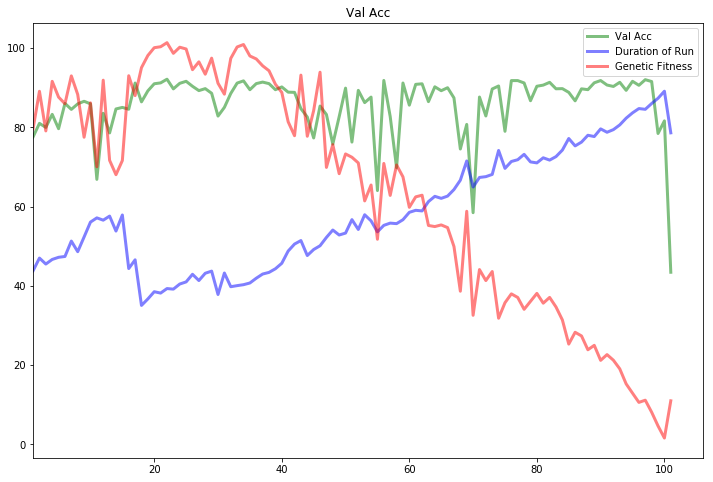

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title("Val Acc")
ax.plot(boink.index.values + 1, boink.loc[:, "Peak_Val_Acc"].values, label="Val Acc", color="green", lw=3.0, alpha=0.5)
ax.plot(boink.index.values + 1, boink.loc[:, "Train_Time"].values, label="Duration of Run", color="blue", lw=3.0, alpha=0.5)
ax.plot(boink.index.values + 1, boink.loc[:, "Fitness"].values, label="Genetic Fitness", color="red", lw=3.0, alpha=0.5)

ax.set_xlim(1)

ax.legend()

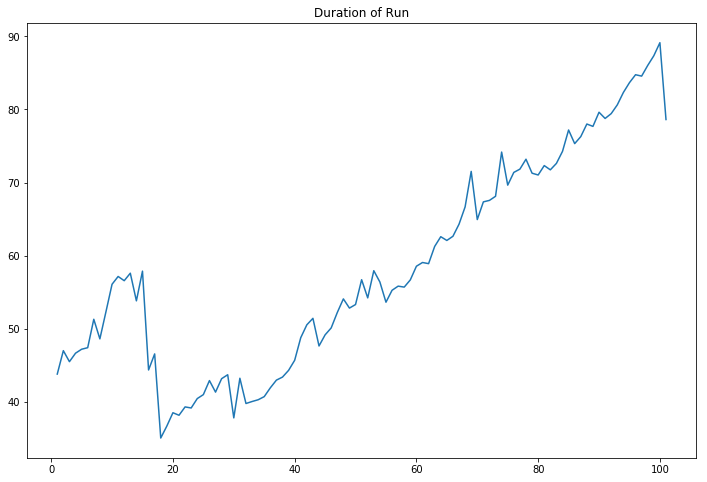

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title("Duration of Run")


In [2]:
import numpy as np
boink = [1, 3, 4]

med = np.median(boink)

boink.index(med)

1